In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyproj import Transformer

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression

from sklearn.cluster import KMeans

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [278]:
#기본 정보
coord_std=pd.read_excel('./기본정보_위경도.xlsx')

#숙박 유형
pension=pd.read_excel("./숙박유형_관광펜션업.xlsx")
camping=pd.read_excel("./숙박유형_일반야영장업.xlsx")
hanok=pd.read_excel("./숙박유형_한옥체험업.xlsx")
resort=pd.read_excel("./숙박유형_호텔리조트.xlsx") 

#비대면
alien1=pd.read_csv('./비대면_외지인방문자수_1.csv',encoding='cp949')
alien2=pd.read_csv('./비대면_외지인방문자수_2.csv',encoding='cp949')
resider1=pd.read_csv('./비대면_현지인방문자수_1.csv',encoding='cp949')
resider2=pd.read_csv('./비대면_현지인방문자수_2.csv',encoding='cp949')

#식음및부대시설
meal=pd.read_csv('./부대시설_음식점.csv',encoding='cp949')
cafe=pd.read_csv('./부대시설_휴게음식점.csv',encoding='utf-8')

#콘텐츠
contents1=pd.read_csv('./콘텐츠_관광지_검색순위_상.csv',encoding='cp949')
contents2=pd.read_csv('./콘텐츠_관광지_검색순위_하.csv',encoding='cp949')

In [279]:
#xy좌표를 위경도로 변환
transformer = Transformer.from_crs(2097, 4326)

def convert_coordinates(lon, lat):
    new_lat, new_lon = transformer.transform(lat, lon) 
    return new_lon, new_lat

# 데이터 준비

숙소

In [280]:
#숙소
def accomm_preprocess(accomm):
    accomm.drop(accomm[(accomm['영업상태구분코드']!=1)].index,inplace=True)
    accomm=accomm[accomm['개방자치단체코드'].between(4800000,5010000)]
    accomm=accomm.loc[:,['개방자치단체코드','좌표정보(X)','좌표정보(Y)']]
    accomm.dropna(axis=0,inplace=True)
    return accomm

pension=accomm_preprocess(pension)
camping=accomm_preprocess(camping)
hanok=accomm_preprocess(hanok)
resort=accomm_preprocess(resort)

In [281]:
pension['경도'], pension['위도'] = zip(*pension.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))
camping['경도'], camping['위도'] = zip(*camping.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))
hanok['경도'], hanok['위도'] = zip(*hanok.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))
resort['경도'], resort['위도'] = zip(*resort.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))

In [282]:
accomm_df=pd.concat([pension,camping,hanok,resort],ignore_index=True)
accomm_df.drop(['좌표정보(X)','좌표정보(Y)'],axis=1,inplace=True)

In [283]:
acco_n=list(accomm_df['개방자치단체코드'].value_counts()) #지역별 숙소 개수

부대시설(카페)

In [284]:
#카페
def cafe_preprocess(cafe):
    cafe.drop(cafe[(cafe['영업상태명']!='영업/정상')].index,inplace=True)
    cafe=cafe.loc[:,['소재지전체주소','좌표정보(X)','좌표정보(Y)']]
    cafe.dropna(axis=0,inplace=True)
    return cafe

cafe=cafe_preprocess(cafe)
cafe['경도'], cafe['위도'] = zip(*cafe.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))

In [285]:
cafe_address=cafe['소재지전체주소']
cafe_address_fr=cafe_address.str.slice(start=4, stop=9, step=1)
cafe_n=list(cafe_address_fr.value_counts())

매력 요소: 비대면 지수, 외부 유입 지수

In [286]:
alien=pd.concat([alien1,alien2],axis=1,ignore_index=True)
alien.drop([2],axis=1,inplace=True) #순위 제거
alien['외지인방문자_평균']=(alien[1]+alien[3])/2
alien['외지인방문자_변화량']=alien[3]-alien[1]


resider=pd.concat([resider1,resider2],axis=1,ignore_index=True)
resider.drop([2],axis=1,inplace=True)
resider['현지인방문자_평균']=(resider[1]+resider[3])/2
resider['현지인방문자_변화량']=resider[3]-resider[1]

attract_index=alien.index
ref_score=(alien['외지인방문자_평균']/resider['현지인방문자_평균'])*100 #선행연구 

attract_df=pd.concat([alien[0],alien['외지인방문자_평균'],alien['외지인방문자_변화량'],
                      resider['현지인방문자_평균'],resider['현지인방문자_변화량'],
                      ref_score],axis=1)
attract_col=['지역','외지인_평균','외지인_변화량','현지인_평균','현지인_변화량','비대면지수']
attract_df.columns=attract_col

In [287]:
attract_df['숙소개수']=acco_n
attract_df['카페개수']=cafe_n
print(attract_df) #1차 데이터 프레임 생성

     지역      외지인_평균    외지인_변화량      현지인_평균    현지인_변화량       비대면지수  숙소개수  카페개수
0   목포시  25342577.5  1375735.0  61463293.0  4834018.0   41.232053   268  1226
1   여수시  27043371.0   860290.0  54737364.5  4424665.0   49.405687   143  1179
2   순천시  25939672.5  2755781.0  60239103.5  4817389.0   43.061186    70   860
3   나주시  16335163.0    37614.0  26343338.0  1961084.0   62.008706    52   563
4   광양시  13620096.0   583696.0  27746306.0  2652488.0   49.087961    44   416
5   담양군  15548173.0   580902.0   9472426.5   965485.0  164.141395    43   366
6   곡성군   5699939.0   456798.0   5125011.5   247975.0  111.218072    39   264
7   구례군   5957218.5   465727.0   5052521.5   505985.0  117.905852    37   261
8   고흥군   6804036.5   -21535.0   9776511.5  1026949.0   69.595750    28   260
9   보성군   7103425.0   468294.0   7201938.0   680620.0   98.632132    27   193
10  화순군  12512281.5   545023.0  14853480.0   853464.0   84.238047    27   167
11  장흥군   5282706.0   319140.0   9099501.5   684541.0   58.05489

콘텐츠

In [288]:
contents2.drop('광역시/도',axis=1,inplace=True)

451
['순천만국가정원', '목포역', '순천역', '죽녹원', '오동도', '여수해상케이블카놀아정류장', 'LF스퀘어광양점', '완도항여객선터미널', '향일암', '목포해상케이블카북항승강장', '아쿠아플라넷여수', '여수엑스포역', '목포종합버스터미널', '화엄사', '나주역', '여수예술랜드', '목포연안여객선터미널', '녹동항', '롯데아울렛남악점', '백양사', '여수공항', '메타프로방스', '순천종합버스터미널', '순천만습지', '낙안읍성민속마을', '섬진강기차마을', '유월드루지테마파크', '율포해수욕장', '영광종합버스터미널', '선암사', '아르떼뮤지엄여수', '불갑사', '송광사', '진도항', '녹동신항연안여객선터미널', 'NC백화점순천점', '여수수산시장', '돌산공원', '무안CC', 'CGV순천신대', '장성역', '푸른솔GC', '무안국제공항', '호남해안로드4코스영광백수해안도로', '여수수산물특화시장', '대흥사', '벌교역', '목포항국제여객터미널', '골드레이크CC', '해남종합버스터미널', '담양관방제림', '사성암', '여수종합버스터미널', '여천역', '암태남강선착장', '중마버스터미널', '신지명사십리해수욕장', '무등산CC', '만성리검은모래해변', '메타세쿼이아가로수길', '구례구역', '순천아랫장', '운림산방', '순천오픈세트장', '아크로CC', '여수연안여객선터미널', '정남진장흥토요시장', '강진버스여객터미널', '신기항여객터미널', 'JNJ골프리조트', '소쇄원', '갓바위', '함평엘리체CC', '나로우주센터우주과학관', '천은사', '진남관공사중(2023년12월완공예정)', '땅끝전망대', '골프존카운티순천', '돌머리해변', '무안시외버스터미널', '목포북항', '땅끝선착장', '여수구항방파제등대', '목포근대역사관1관', '청호시장', '다산베아채CC', '파인비치골프링크스', '목포종합수산시장', '화순CC', '웅천친수공원', '광주CC', '메타세콰이어길', '사우스링스영암CC짐앵', '파인힐

Text(0.5, 1.0, '전라남도 관광지 검색량')

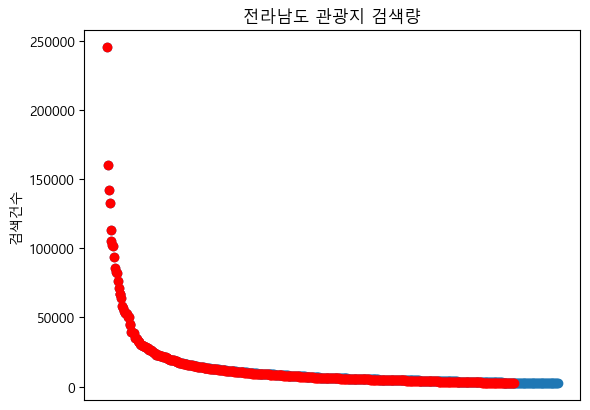

In [289]:
count_num=0
sites=[]
rnum=[]

for i in range(len(contents2)): #22'09~23'08
   for j in range(len(contents1)): #21'09~22'08
        if contents2['관광지명'][i]==contents1['관광지명'][j]:
            count_num+=1
            sites.append(contents2['관광지명'][i])
            rnum.append(contents2['검색건수'][i])

print(count_num) #451: 인기 관광지 500곳 중 451곳은 반복해서 수요가 많다.
print(sites) #사람들이 반복해서 찾는 곳

x1=np.arange(len(contents2))
plt.scatter(x1,contents2['검색건수'])
x2=np.arange(len(rnum))
plt.scatter(x2,rnum,c='r')

plt.xticks([])

plt.ylabel('검색건수')
plt.title('전라남도 관광지 검색량') #가는 곳(만) 또 감

In [290]:
contents_agg=contents2.iloc[0:452]
contents_agg.drop(['순위'],axis=1)

,시/군/구,관광지명,도로명주소,중분류 카테고리,소분류 카테고리,검색건수
0,순천시,순천만국가정원,전남 순천시 국가정원1호길 47-0,기타관광,기타관광,245254
1,목포시,목포역,전남 목포시 영산로 98-0,기타관광,교통시설,159899
2,순천시,순천역,전남 순천시 팔마로 135-0,기타관광,교통시설,141882
3,담양군,죽녹원,전남 담양군 죽녹원로 119-0,자연관광,자연공원,132973
4,여수시,오동도,전남 여수시 오동도로 222-0,자연관광,자연경관(하천/해양),113284
...,...,...,...,...,...,...
447,순천시,순천만달밤야시장,전남 순천시,쇼핑,시장,2933
448,고흥군,능가사,전남 고흥군 팔봉길 21-0,역사관광,종교성지,2933
449,목포시,목포해양경찰서전용부두,전남 목포시 고하대로597번길 99-64,자연관광,자연경관(하천/해양),2918
450,강진군,마량놀토수산시장,전남 강진군 미항로 152-0,쇼핑,시장,2895


In [381]:
yeosu=pd.read_csv('./전라남도_여수시_관광지정보_20221122.csv',encoding='cp949')
mokpo=pd.read_csv('./전라남도_목포시_관광지정보_20230713.csv',encoding='cp949')
suncheon=pd.read_csv('./전라남도_순천시_관광지정보_20230726.csv',encoding='cp949')

gwangyang=pd.read_csv('./전라남도_광양시_관광지정보_20221024.csv',encoding='cp949')
muan=pd.read_csv('./전라남도_무안군_관광지정보_20230418.csv',encoding='cp949')

damyang=pd.read_csv('./전라남도_담양군_관광지정보_20230913.csv',encoding='cp949')

naju=pd.read_csv('./전라남도_나주시_관광지정보_20221130.csv',encoding='cp949')
hwasun=pd.read_csv('./전라남도_화순군_관광지정보_20230807.csv',encoding='cp949')
yeonggwang=pd.read_csv('./전라남도_영광군_관광지정보_20220917.csv',encoding='cp949')
haenam=pd.read_csv('./전라남도_해남군_관광지정보_20231129.csv',encoding='cp949')
gangjin=pd.read_csv('./전라남도_강진군_관광지정보_20230721.csv',encoding='cp949')
gurye=pd.read_csv('./전라남도_구례군_관광지정보_20230718.csv',encoding='cp949')
wando=pd.read_csv('./전라남도_완도군_관광지정보_20200911_1601266010100_4152.csv',encoding='cp949')
boseong=pd.read_csv('./전라남도_보성군_관광지정보_20230713.csv',encoding='cp949')
jangseong=pd.read_csv('./전라남도_장성군_관광지정보_20231126.csv',encoding='cp949')
jindo=pd.read_csv('./전라남도_진도군_관광지정보_20230828.csv',encoding='cp949')
shinan=pd.read_csv('./전라남도_신안군_관광지정보_20230501.csv',encoding='cp949')
hampyeong=pd.read_csv('./전라남도_함평군_관광지정보_20221109.csv',encoding='cp949')
yeongam=pd.read_csv('./전라남도_영암군_관광지정보_20230208.csv',encoding='cp949')
gokseong=pd.read_csv('./전라남도_곡성군_관광지정보_20230801.csv',encoding='cp949')

#고흥군, 장흥군 없음

In [292]:
def sites_preprocess(s):
    s=s[['관광지명','위도','경도']]
    return s

yeosu=sites_preprocess(yeosu)
mokpo=sites_preprocess(mokpo)
suncheon=sites_preprocess(suncheon)

gwangyang=sites_preprocess(gwangyang)
naju=sites_preprocess(naju)

hwasun=sites_preprocess(hwasun)
damyang=sites_preprocess(damyang)
yeonggwang=sites_preprocess(yeonggwang)
haenam=sites_preprocess(haenam)
gangjin=sites_preprocess(gangjin)

gurye=sites_preprocess(gurye)
wando=sites_preprocess(wando)
boseong=sites_preprocess(boseong)
jangseong=sites_preprocess(jangseong)
jindo=sites_preprocess(jindo)

muan=sites_preprocess(muan)
shinan=sites_preprocess(shinan)
hampyeong=sites_preprocess(hampyeong)
yeongam=sites_preprocess(yeongam)
gokseong=sites_preprocess(gokseong)

In [ ]:
# sites_list=[yeosu,mokpo,suncheon,
#             gwangyang,muan,
#             damyang, 
#             naju,hwasun, yeonggwang, haenam, gangjin,gurye, wando, boseong, 
#             jangseong, jindo, shinan, hampyeong, yeongam, gokseong]

In [379]:
def city_counter(cityname):
    city=contents_agg.loc[contents_agg['시/군/구']==cityname]
    city_num=len(city)
    print(city_num)
    return city #작업잘됨

def city_coord_preprocess(city):
    city_lat=[0]*len(city)
    city_long=[0]*len(city)
    return city_lat,city_long

def city_coord_collect(cityname):
    cityname_lat=cityname['위도']
    cityname_long=cityname['경도']
    return cityname_lat,cityname_long

def city_coord_agg(city,cityname,city_lat,city_long,cityname_lat,cityname_long):
    tour_spot=city['관광지명']
    tour_attr=cityname['관광지명']
    for i in range(len(city)):
        for j in range(len(cityname)):
            if tour_spot.iloc[i]==tour_attr.iloc[j]:
             city_lat[i]=cityname_lat.iloc[j]
             city_long[i]=cityname_long.iloc[j]
    city['위도']=city_lat
    city['경도']=city_long
    return city

In [409]:
#유형1
ys=city_counter('여수시')
ys_lat,ys_long=city_coord_preprocess(ys)
yeosu_lat,yeosu_long=city_coord_collect(yeosu)
ys=city_coord_agg(ys,yeosu,ys_lat,ys_long,
               yeosu_lat,yeosu_long)

mp=city_counter('목포시')
mp_lat,mp_long=city_coord_preprocess(mp)
mokpo_lat,mokpo_long=city_coord_collect(mokpo)
mp=city_coord_agg(mp,gwangyang,mp_lat,mp_long,
               mokpo_lat,mokpo_long)

sc=city_counter('순천시')
sc_lat,sc_long=city_coord_preprocess(sc)
suncheon_lat,suncheon_long=city_coord_collect(suncheon)
sc=city_coord_agg(sc,suncheon,sc_lat,sc_long,
               suncheon_lat,suncheon_long)

#유형2
gy=city_counter('광양시')
gy_lat,gy_long=city_coord_preprocess(gy)
gwangyang_lat,gwangyang_long=city_coord_collect(gwangyang)
gy=city_coord_agg(gy,gwangyang,gy_lat,gy_long,
               gwangyang_lat,gwangyang_long)

mn=city_counter('무안군')
mn_lat,mn_long=city_coord_preprocess(mn)
muan_lat,muan_long=city_coord_collect(muan)
mn=city_coord_agg(mn,muan,mn_lat,mn_long,
               muan_lat,muan_long)


#유형3
dy=city_counter('담양군')
dy_lat,dy_long=city_coord_preprocess(dy)
damyang_lat,damyang_long=city_coord_collect(damyang)
dy=city_coord_agg(dy,damyang,dy_lat,dy_long,
               damyang_lat,damyang_long)


72
40
39
24
14
21


C:\Users\user\AppData\Local\Temp\ipykernel_107328\3976244996.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city['위도']=city_lat
C:\Users\user\AppData\Local\Temp\ipykernel_107328\3976244996.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city['경도']=city_long
C:\Users\user\AppData\Local\Temp\ipykernel_107328\3976244996.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [420]:
#누락 좌표 채우기: 1.여수
ys.loc[5,'위도']=34.73082
ys.loc[5,'경도']=127.7416

ys.loc[10,'위도']=34.74668
ys.loc[10,'경도']=127.7483

ys.loc[11,'위도']=34.75344
ys.loc[11,'경도']=127.7490

ys.loc[15,'위도']=34.69521
ys.loc[15,'경도']=127.7775

ys.loc[20,'위도']=34.84031
ys.loc[20,'경도']=127.6141

ys.loc[26,'위도']=34.74794
ys.loc[26,'경도']=127.7490

ys.loc[30,'위도']=34.75077
ys.loc[30,'경도']=127.7460

ys.loc[36,'위도']=34.73839 
ys.loc[36,'경도']=127.7317

ys.loc[37,'위도']=34.73084
ys.loc[37,'경도']=127.7407

ys.loc[44,'위도']=34.73701
ys.loc[44,'경도']=127.7338

ys.loc[52,'위도']=34.75832
ys.loc[52,'경도']=127.7177

ys.loc[53,'위도']=34.77914 
ys.loc[53,'경도']=127.6644

ys.loc[58,'위도']=34.77826
ys.loc[58,'경도']=127.7449

ys.loc[65,'위도']=34.73877
ys.loc[65,'경도']=127.7322
ys.loc[68,'위도']=34.60234
ys.loc[68,'경도']=127.7433

ys.loc[75,'위도']=34.74218 
ys.loc[75,'경도']=127.7371

ys.loc[82,'위도']=34.73644  
ys.loc[82,'경도']=127.74710

ys.loc[90,'위도']=34.74751
ys.loc[90,'경도']=127.6688

ys.loc[103,'위도']=34.75455 
ys.loc[103,'경도']=127.7532

ys.loc[114,'위도']=34.73078
ys.loc[114,'경도']=127.7419

ys.loc[126,'위도']=34.68384 
ys.loc[126,'경도']=127.7767

ys.loc[130,'위도']=34.77265
ys.loc[130,'경도']=127.7473

ys.loc[143,'위도']=34.72898 
ys.loc[143,'경도']=127.7274

ys.loc[146,'위도']=34.6207 
ys.loc[146,'경도']=127.6441

ys.loc[149,'위도']=34.74198
ys.loc[149,'경도']=127.7291

ys.loc[162,'위도']=34.72961 
ys.loc[162,'경도']=127.7377

ys.loc[171,'위도']=34.71367 
ys.loc[171,'경도']=127.7252

ys.loc[183,'위도']=34.77453 
ys.loc[183,'경도']=127.7267

ys.loc[190,'위도']=34.75
ys.loc[190,'경도']=127.665

ys.loc[193,'위도']=34.7389
ys.loc[193,'경도']=127.7302

ys.loc[194,'위도']=34.7775 
ys.loc[194,'경도']=127.6883

ys.loc[214,'위도']=34.7285
ys.loc[214,'경도']=127.7216
ys.loc[219,'위도']=34.64929
ys.loc[219,'경도']=127.6289

ys.loc[221,'위도']=34.74110
ys.loc[221,'경도']=127.7560

ys.loc[230,'위도']=34.73217
ys.loc[230,'경도']=127.6441

ys.loc[231,'위도']=34.74955 
ys.loc[231,'경도']=127.6798

ys.loc[239,'위도']=34.71729
ys.loc[239,'경도']=127.7488

ys.loc[241,'위도']=34.73005 
ys.loc[241,'경도']=127.7375
ys.loc[254,'위도']=34.73917
ys.loc[254,'경도']=127.7420

ys.loc[256,'위도']=34.73895
ys.loc[256,'경도']=127.6515

ys.loc[258,'위도']=34.72666
ys.loc[258,'경도']=127.7219

ys.loc[260,'위도']=34.77823
ys.loc[260,'경도']=127.6513

ys.loc[268,'위도']=34.82128
ys.loc[268,'경도']=127.7005

ys.loc[275,'위도']=34.68439
ys.loc[275,'경도']=127.7785
ys.loc[292,'위도']=34.74061
ys.loc[292,'경도']=127.7332

ys.loc[294,'위도']=34.60443
ys.loc[294,'경도']=127.5390

ys.loc[313,'위도']=34.72796
ys.loc[313,'경도']=127.7257

ys.loc[326,'위도']=34.74484
ys.loc[326,'경도']=127.6533

ys.loc[331,'위도']=34.74888
ys.loc[331,'경도']=127.6795

ys.loc[344,'위도']=34.79761
ys.loc[344,'경도']=127.7604

ys.loc[345,'위도']=34.75013
ys.loc[345,'경도']=127.6426

ys.loc[348,'위도']=34.74842
ys.loc[348,'경도']=127.6629

ys.loc[349,'위도']=34.77459
ys.loc[349,'경도']=127.6461
ys.loc[352,'위도']=34.74957 
ys.loc[352,'경도']=127.7478

ys.loc[356,'위도']=34.68400 
ys.loc[356,'경도']=127.6287

ys.loc[370,'위도']=34.61730 
ys.loc[370,'경도']=127.7560

ys.loc[374,'위도']=34.75283
ys.loc[374,'경도']=127.7511

ys.loc[378,'위도']=34.84403
ys.loc[378,'경도']=128.4429

ys.loc[386,'위도']=34.88944 
ys.loc[386,'경도']=127.7050

ys.loc[391,'위도']=34.62050
ys.loc[391,'경도']=127.6411

ys.loc[395,'위도']=34.63087
ys.loc[395,'경도']=127.7936
ys.loc[400,'위도']=34.61529 
ys.loc[400,'경도']=127.7234

ys.loc[412,'위도']=34.66090
ys.loc[412,'경도']=127.8056

ys.loc[414,'위도']=34.74367 
ys.loc[414,'경도']=127.6649

ys.loc[420,'위도']=34.76432
ys.loc[420,'경도']=127.6645

ys.loc[428,'위도']=34.83987
ys.loc[428,'경도']=127.6728

ys.loc[433,'위도']=34.72497 
ys.loc[433,'경도']=127.7115

ys.loc[451,'위도']=34.75086
ys.loc[451,'경도']=127.7492

In [458]:
#누락 좌표 채우기: 2.순천

sc.loc[2,'위도']=34.94584
sc.loc[2,'경도']=127.5032

sc.loc[22,'위도']=34.94777
sc.loc[22,'경도']=127.4914

sc.loc[24,'위도']=34.90744
sc.loc[24,'경도']=127.3420

sc.loc[35,'위도']=34.97271 
sc.loc[35,'경도']=127.5210

sc.loc[39,'위도']=34.92624
sc.loc[39,'경도']=127.5524

sc.loc[60,'위도']=35.16348
sc.loc[60,'경도']=127.4526

sc.loc[61,'위도']=34.94578
sc.loc[61,'경도']=127.4948

sc.loc[63,'위도']=34.95782 
sc.loc[63,'경도']=127.5384

sc.loc[77,'위도']=35.04482
sc.loc[77,'경도']=127.3085

sc.loc[94,'위도']=35.03434 
sc.loc[94,'경도']=127.2722

sc.loc[105,'위도']=34.84672
sc.loc[105,'경도']=127.5253

sc.loc[116,'위도']=34.96650 
sc.loc[116,'경도']=127.5238

sc.loc[121,'위도']=34.91692 
sc.loc[121,'경도']=127.5364

sc.loc[135,'위도']=34.92866 
sc.loc[135,'경도']=127.4982

sc.loc[142,'위도']=34.92866 
sc.loc[142,'경도']=127.4982

sc.loc[154,'위도']=34.95906
sc.loc[154,'경도']=127.4853

sc.loc[164,'위도']=34.93349
sc.loc[164,'경도']=127.4979

sc.loc[184,'위도']=34.90181
sc.loc[184,'경도']=127.4477

sc.loc[196,'위도']=34.94150 
sc.loc[196,'경도']=127.5109

sc.loc[198,'위도']=34.92643
sc.loc[198,'경도']=127.5447

sc.loc[246,'위도']=34.88318 
sc.loc[246,'경도']=127.5139

sc.loc[293,'위도']=34.95169
sc.loc[293,'경도']=127.4892

sc.loc[298,'위도']=34.94024
sc.loc[298,'경도']=127.5557

sc.loc[300,'위도']=34.92858
sc.loc[300,'경도']=127.4983

sc.loc[311,'위도']=34.94399
sc.loc[311,'경도']=127.5035

sc.loc[334,'위도']=34.92924 
sc.loc[334,'경도']=127.5245

sc.loc[339,'위도']=34.86727
sc.loc[339,'경도']=127.4057

sc.loc[353,'위도']=34.95342 
sc.loc[353,'경도']=127.4845

sc.loc[357,'위도']=34.95398
sc.loc[357,'경도']=127.4951

sc.loc[379,'위도']=34.94803 
sc.loc[379,'경도']=127.4988

sc.loc[408,'위도']=34.91536
sc.loc[408,'경도']=127.5175

sc.loc[445,'위도']=34.84266
sc.loc[445,'경도']=127.4890

sc.loc[447,'위도']=34.93025
sc.loc[447,'경도']=127.5179

In [466]:
#누락 좌표 채우기: 3.목포
mp_latitude=[34.79273,34.79860,34.81304,34.78199,34.78039,
             34.79354,34.80562,34.78776,34.81572,34.78807,
             34.80426,34.78781,34.79940,34.78861,34.79311,
             34.79167,34.77820,34.78191, 34.82961, 34.78171, 34.75700, 
             34.78296, 34.79374, 34.80320,34.78211, 34.79260, 34.80282,
             34.79234, 34.81250, 34.78599, 34.79464, 34.80714, 34.79802, 
             34.80985, 34.78794, 34.79364, 34.81706, 34.78267, 34.79216, 
             34.78098]

mp_longitude=[126.3882,126.3694,126.4176,126.3844,126.3823,
              126.4257,126.3645,126.3821,126.4245,126.3900,
                126.3921,126.3674,126.4333,126.3749,126.4030,
                126.3766,126.3592,126.3774,126.3964, 126.3832,
                126.3522,126.3922,126.4211,126.4200,126.3888,
                126.3726, 126.4267, 126.4215, 126.4382, 126.3816,
                126.3737,126.4260, 126.3565,126.3773,126.3674,
                126.3914,126.4197,126.3900,126.4258,126.3884]

mp['경도']=mp_latitude
mp['위도']=mp_longitude

C:\Users\user\AppData\Local\Temp\ipykernel_107328\2962721397.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mp['경도']=mp_latitude
C:\Users\user\AppData\Local\Temp\ipykernel_107328\2962721397.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mp['위도']=mp_longitude


In [487]:
#누락 좌표 채우기: 4. 광양

gy.loc[6,'위도']=34.96314 
gy.loc[6,'경도']=127.5662

gy.loc[55,'위도']=34.93621
gy.loc[55,'경도']=127.6993

gy.loc[107,'위도']=34.96962 
gy.loc[107,'경도']=127.5898

gy.loc[119,'위도']=34.93820 
gy.loc[119,'경도']=127.6989

gy.loc[160,'위도']=35.07488
gy.loc[160,'경도']=127.7163

gy.loc[182,'위도']=34.93564
gy.loc[182,'경도']=127.7231

gy.loc[249,'위도']=34.96776 
gy.loc[249,'경도']=127.5889

gy.loc[266,'위도']=34.96738 
gy.loc[266,'경도']=127.7580

gy.loc[288,'위도']=34.95651
gy.loc[288,'경도']= 127.5876

gy.loc[291,'위도']=34.93318 
gy.loc[291,'경도']=127.7275

gy.loc[318,'위도']=34.96181
gy.loc[318,'경도']=127.5655

gy.loc[322,'위도']=34.94322
gy.loc[322,'경도']=127.7259

gy.loc[329,'위도']=34.97111
gy.loc[329,'경도']=127.5904

gy.loc[361,'위도']=35.06914
gy.loc[361,'경도']=127.6342

gy.loc[373,'위도']=34.92992
gy.loc[373,'경도']=127.7151

gy.loc[383,'위도']=34.91296
gy.loc[383,'경도']=127.6821

gy.loc[392,'위도']=34.94024
gy.loc[392,'경도']=127.7321

gy.loc[397,'위도']=34.98831 
gy.loc[397,'경도']=127.7011

gy.loc[416,'위도']=34.95549
gy.loc[416,'경도']=127.7079

gy.loc[446,'위도']=34.91549
gy.loc[446,'경도']=127.6813

In [500]:
#누락 좌표 채우기: 5. 무안
mn.loc[18,'위도']=34.80346
mn.loc[18,'경도']=126.4644

mn.loc[38,'위도']=34.96715
mn.loc[38,'경도']=126.4079

mn.loc[42,'위도']=34.99364
mn.loc[42,'경도']=126.3878

mn.loc[79,'위도']=34.98803
mn.loc[79,'경도']=126.4787

mn.loc[104,'위도']=34.86293
mn.loc[104,'경도']=126.5255

mn.loc[129,'위도']=34.94474
mn.loc[129,'경도']=126.4581

mn.loc[168,'위도']=34.96830
mn.loc[168,'경도']=126.3862

mn.loc[192,'위도']=35.10378
mn.loc[192,'경도']=126.3330

mn.loc[272,'위도']=34.99482
mn.loc[272,'경도']=126.3342

mn.loc[297,'위도']=35.06271
mn.loc[297,'경도']=126.3385

mn.loc[302,'위도']=35.06137
mn.loc[302,'경도']=126.3373

mn.loc[335,'위도']=34.99339
mn.loc[335,'경도']=126.4727

mn.loc[403,'위도']=34.92987
mn.loc[403,'경도']=126.5032

mn.loc[410,'위도']=34.96199 
mn.loc[410,'경도']=126.2979

In [517]:
#누락 좌표 채우기: 6. 담양
dy.loc[21,'위도']=35.32208 
dy.loc[21,'경도']=127.0018

dy.loc[50,'위도']=35.32375 
dy.loc[50,'경도']=126.9892

dy.loc[59,'위도']=35.32451 
dy.loc[59,'경도']=127.0065

dy.loc[70,'위도']=35.18435 
dy.loc[70,'경도']=127.0122

dy.loc[84,'위도']=35.33707
dy.loc[84,'경도']=126.9563

dy.loc[92,'위도']=35.32444
dy.loc[92,'경도']=127.0065

dy.loc[102,'위도']=35.23813
dy.loc[102,'경도']=127.0144

dy.loc[110,'위도']=35.30889
dy.loc[110,'경도']=127.0191

dy.loc[120,'위도']=35.36550
dy.loc[120,'경도']=127.0256

dy.loc[124,'위도']=35.31523
dy.loc[124,'경도']=126.9839

dy.loc[177,'위도']=35.32294
dy.loc[177,'경도']=127.0055

dy.loc[189,'위도']=35.39967 
dy.loc[189,'경도']=126.9757

dy.loc[215,'위도']=35.22244 
dy.loc[215,'경도']=127.0149

dy.loc[314,'위도']=35.37226
dy.loc[314,'경도']=127.0196

dy.loc[321,'위도']=35.27856
dy.loc[321,'경도']=126.8940

dy.loc[321,'위도']=35.27856
dy.loc[321,'경도']=126.8940

dy.loc[321,'위도']=35.27856
dy.loc[321,'경도']=126.8940

dy.loc[321,'위도']=35.27856
dy.loc[321,'경도']=126.8940

dy.loc[321,'위도']=35.27856
dy.loc[321,'경도']=126.8940

In [518]:
dy

,순위,시/군/구,관광지명,도로명주소,중분류 카테고리,소분류 카테고리,검색건수,위도,경도
3,4,담양군,죽녹원,전남 담양군 죽녹원로 119-0,자연관광,자연공원,132973,35.325357,126.986615
21,22,담양군,메타프로방스,전남 담양군 메타프로방스1길 17-0,문화관광,복합관광시설,53133,35.322080,127.001800
50,51,담양군,담양관방제림,전남 담양군,역사관광,역사유적지,26142,35.323750,126.989200
59,60,담양군,메타세쿼이아가로수길,전남 담양군,기타관광,기타관광,22271,35.324510,127.006500
70,71,담양군,소쇄원,전남 담양군 소쇄원길 17-0,역사관광,역사유적지,19647,35.184350,127.012200
84,85,담양군,딜라이트 담양,전남 담양군 화방송정길 21-14,문화관광,전시시설,16895,35.337070,126.956300
92,93,담양군,메타세콰이어길,전남 담양군,기타관광,데이트코스,15803,35.324440,127.006500
102,103,담양군,창평시장,전남 담양군 사동길 14-24,쇼핑,시장,14182,35.238130,127.014400
110,111,담양군,담양레이나CC,전남 담양군 깊은실길 169-0,레저스포츠,육상레저스포츠,13568,35.308890,127.019100
120,121,담양군,담양온천,전남 담양군 금성산성길 202-0,체험관광,웰니스관광,12912,35.365500,127.025600


In [385]:
ct2=contents2.drop_duplicates(subset=['시/군/구'])
contents_df=ct2.drop(['중분류 카테고리','순위','관광지명','도로명주소'], axis=1).reset_index(drop=True)

In [298]:
visit=[]
contents_keyword=[]

for i in range(len(meal)):
    for j in range(len(contents_df)):
        if meal['항목'][i]==contents_df['시/군/구'][j]:
            visit.append(contents_df['검색건수'][j])
            contents_keyword.append(contents_df['소분류 카테고리'][j])

meal['검색건수']=visit
meal['지역_키워드']=contents_keyword

In [299]:
meal_columns=['항목','음식점개수','경도','위도','검색건수','지역키워드']
meal.columns=meal_columns

In [300]:
meal['관광지']=[76,41,40,26,25,19,25,12,16,23,18,
                        23,21,16,18,13,17,18,14,16,11,12]
print(meal)

     항목  음식점개수          경도         위도    검색건수        지역키워드  관광지
0   여수시   3875  127.662222  34.760374  113284  자연경관(하천/해양)   76
1   순천시   3157  127.483333  34.950000  245254         기타관광   41
2   목포시   2977  126.350000  34.766667  159899         교통시설   40
3   광양시   1974  127.695501  34.940548  102492          쇼핑몰   26
4   나주시   1343  126.716667  35.033333   66728         교통시설   25
5   무안군   1016  126.481686  34.990454   57042          쇼핑몰   19
6   해남군    798  126.598927  34.573252   27724         종교성지   25
7   영암군    696  126.696792  34.800169   21308      육상레저스포츠   12
8   고흥군    689  127.284978  34.611222   58260  자연경관(하천/해양)   16
9   화순군    654  126.986480  35.064503   22783      육상레저스포츠   23
10  완도군    610  126.755054  34.311060  101505         교통시설   18
11  담양군    586  126.988167  35.321139  132973         자연공원   23
12  영광군    582  126.511987  35.277172   39224         교통시설   21
13  보성군    494  127.079894  34.771456   39860  자연경관(하천/해양)   16
14  장성군    476  126.784854  35.301833   

In [301]:
a_index=attract_df['지역']
m_index=meal['항목']

calmness=[]
accommodation=[]
cafeteria=[]

entranger_avg=[]
entranger_diff=[]
aborigene_avg=[]
aborigene_diff=[]


for i in range(len(meal)):
    for j in range(len(attract_df)):
        if m_index[i]==a_index[j]:
            calmness.append(attract_df['비대면지수'][j])
            accommodation.append(attract_df['숙소개수'][j])
            cafeteria.append(attract_df['카페개수'][j])
            aborigene_avg.append(attract_df['현지인_평균'][j])
            aborigene_diff.append(attract_df['현지인_변화량'][j])
            entranger_avg.append(attract_df['외지인_평균'][j])
            entranger_diff.append(attract_df['외지인_변화량'][j])
        else:
            continue


meal['비대면지수']=calmness
meal['숙소개수']=accommodation
meal['카페개수']=cafeteria

meal['현지인_평균']=aborigene_avg
meal['현지인_변화량']=aborigene_diff

meal['외지인_평균']=entranger_avg
meal['외지인_변화량']=entranger_diff

meal['음식점개수']=meal['음식점개수'].astype('int64')

# 특성 스케일링(표준화)

: 항목 마다 값이 크게 다르니 이상치에 영향 덜 받는 표준화로 특성 스케일링

In [302]:
ck=pd.get_dummies(contents_keyword,dtype='int64') #지역별 키워드를 원핫 인코딩

feat_df=pd.concat([meal,ck],axis=1,ignore_index=True)

#특성 스케일링용 데이터 프레임
feat_df.drop([2,3,5],axis=1,inplace=True) #경도, 위도,지역키워드, 최종점수 제거
feat_df=feat_df.set_index([0])

feat_df.columns=['음식점개수','검색건수','관광지','비대면지수',
                  '숙소개수','카페개수','현지인_평균','현지인_변화량',
                  '외지인_평균','외지인_변화량','교통시설','기타관광',
                  '쇼핑몰','시장','육상레저스포츠',
                  '자연경관(하천/해양)','자연공원','종교성지']

print(feat_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 여수시 to 함평군
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   음식점개수        22 non-null     int64  
 1   검색건수         22 non-null     int64  
 2   관광지          22 non-null     int64  
 3   비대면지수        22 non-null     float64
 4   숙소개수         22 non-null     int64  
 5   카페개수         22 non-null     int64  
 6   현지인_평균       22 non-null     float64
 7   현지인_변화량      22 non-null     float64
 8   외지인_평균       22 non-null     float64
 9   외지인_변화량      22 non-null     float64
 10  교통시설         22 non-null     int64  
 11  기타관광         22 non-null     int64  
 12  쇼핑몰          22 non-null     int64  
 13  시장           22 non-null     int64  
 14  육상레저스포츠      22 non-null     int64  
 15  자연경관(하천/해양)  22 non-null     int64  
 16  자연공원         22 non-null     int64  
 17  종교성지         22 non-null     int64  
dtypes: float64(5), int64(13)
memory usage: 3.3+ KB
None


In [303]:
scaler=StandardScaler()

f_df=pd.DataFrame((scaler.fit_transform(feat_df)),
                  columns=['음식점개수','검색건수','관광지','비대면지수',
                  '숙소개수','카페개수','현지인_평균','현지인_변화량',
                  '외지인_평균','외지인_변화량','교통시설','기타관광',
                  '쇼핑몰','시장','육상레저스포츠',
                  '자연경관(하천/해양)','자연공원','종교성지'])

<Axes: >

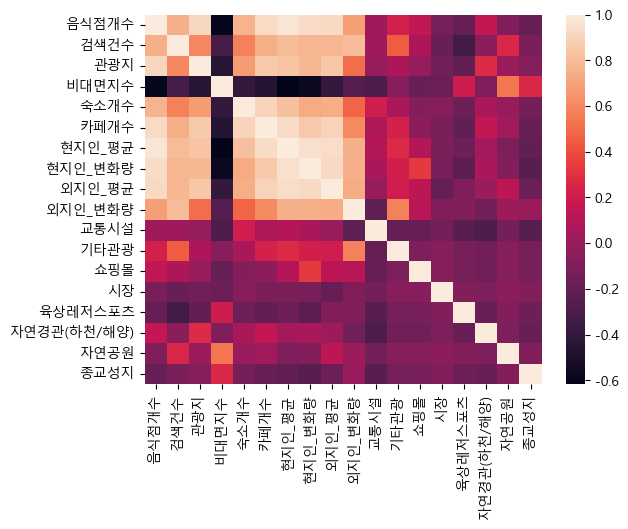

In [304]:
f_corr=f_df.corr()
sns.heatmap(f_corr)

#선행연구에서 제시한 '비대면지수'가 이질적으로 다른 요인과 대조됨.
#새로운 평가지표 개발 필요

In [305]:
#실제 평가된 지역의 워케이션 점수 추가
prof_score=[5,4,3,0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,2,0,0,0]
f_df['최종점수']=prof_score

lr_df=f_df.sort_values(by=['최종점수'],ascending=False).copy()

# 새 평가지표 개발

In [306]:
scored_x=lr_df.iloc[[0,1,2,3,4,5],:-1] #점수 공표된 지역들
tobe_x=lr_df.iloc[6:,:-1]

scored_y=lr_df.iloc[[0,1,2,3,4,5],-1:] #지역별 점수

scored_f=lr_df.iloc[[0,1,2,3,4,5],:]

Text(0, 0.5, '실제 점수')

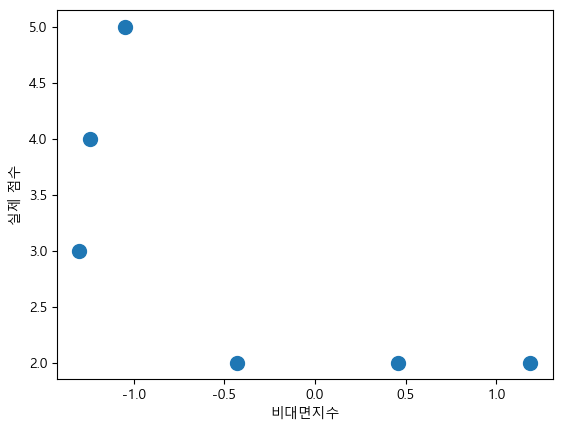

In [307]:
plt.scatter(scored_x['비대면지수'],scored_y,s=100)
plt.xlabel('비대면지수')
plt.ylabel('실제 점수')

#비대면지수가 낮을수록 높은 점수를 받음
#즉 워케이션에 비대면지수를 높게 부여한 선행연구 결과와 (또) 대조

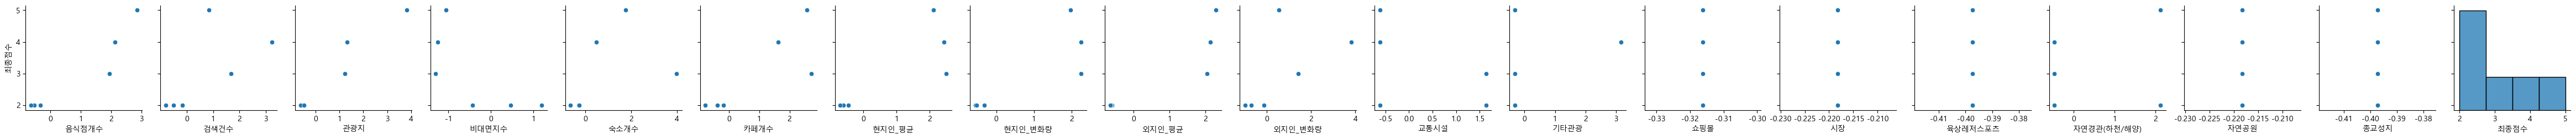

In [308]:
sns.pairplot(scored_f,y_vars=['최종점수'])

In [309]:
poly_features=PolynomialFeatures(degree=2,include_bias=False)

x_poly=poly_features.fit_transform(scored_x)

In [310]:
lr=LinearRegression()

lr.fit(scored_x,scored_y)
predict_y=lr.predict(tobe_x)

lr_df.iloc[6:,-1:]=predict_y

print(lr_df)

       음식점개수      검색건수       관광지     비대면지수      숙소개수      카페개수    현지인_평균  \
0   2.850863  0.836628  3.818339 -1.048810  1.755801  2.580347  2.122529   
1   2.132107  3.231442  1.309703 -1.242790  0.461714  1.623724  2.438057   
2   1.951917  1.682534  1.238028 -1.298716  3.971704  2.721291  2.508266   
13 -0.533698 -0.495772 -0.482179  0.456271 -0.300557 -0.376488 -0.603661   
18 -0.642813 -0.798205 -0.625530  1.187936 -0.655102 -0.772332 -0.692423   
8  -0.338493 -0.161874 -0.482179 -0.431506 -0.282830 -0.175567 -0.456008   
20 -0.713888 -0.397726 -0.840556  0.841082 -0.087830 -0.163572 -0.722775   
19 -0.651822 -0.589554 -0.482179  0.200875 -0.619647 -0.706358 -0.698742   
17 -0.608777  0.078424 -0.338829  1.045558 -0.123285 -0.172568 -0.726932   
16 -0.593761 -0.845168 -0.410504 -0.412144 -0.318284 -0.517432 -0.554437   
15 -0.583751 -0.845077 -0.697205 -0.784363 -0.300557 -0.493442 -0.494835   
14 -0.551717 -0.231376 -0.338829  1.255901 -0.548738 -0.667373 -0.540414   
11 -0.441601

In [311]:
corr_score=lr_df.corrwith(lr_df['최종점수'])
print(corr_score.sort_values(ascending=False))

최종점수           1.000000
관광지            0.957033
음식점개수          0.934554
외지인_평균         0.907142
현지인_평균         0.865225
카페개수           0.839874
현지인_변화량        0.839678
검색건수           0.685810
외지인_변화량        0.652331
숙소개수           0.592140
기타관광           0.238538
자연경관(하천/해양)    0.205544
쇼핑몰            0.107846
자연공원           0.033930
종교성지          -0.109324
교통시설          -0.131745
육상레저스포츠       -0.149801
시장            -0.183984
비대면지수         -0.402990
dtype: float64


# 주성분 분석
데이터의 개수가 매우 적다(22개)는 점 고려해 데이터셋을 대표하는 주성분 추출

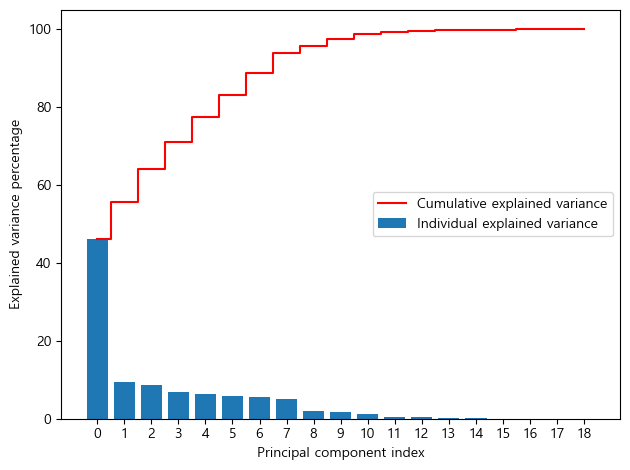

In [313]:
pca = PCA(n_components=None)
pca.fit(f_df)

exp_var = pca.explained_variance_ratio_ * 100 #해당 주성분으로 설명되는 분산 비율
cum_exp_var = np.cumsum(exp_var) #누적 (설명가능) 비율

plt.bar(range(0,19), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(0,19), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(0,19)))
plt.legend(loc=5)
plt.tight_layout()

In [314]:
#(누적)설명 정도가 약 90%에 이르는 7개 선택
pca=PCA(n_components=7)
x_pca=pca.fit_transform(f_df)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

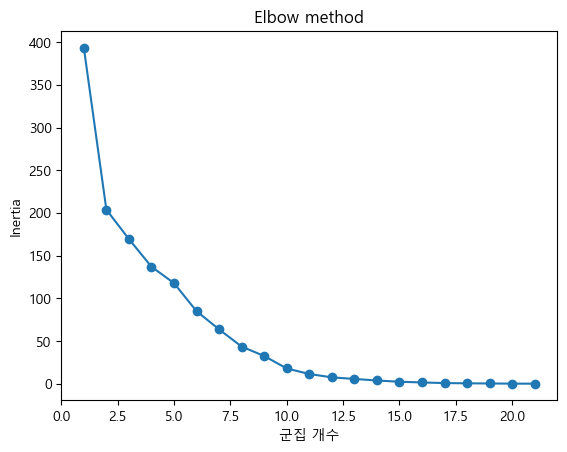

In [315]:
inertias = []

for i in range(1,22):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(x_pca)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,22), inertias, marker='o')

plt.title('Elbow method')
plt.xlabel('군집 개수')
plt.ylabel('Inertia')
plt.show()

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


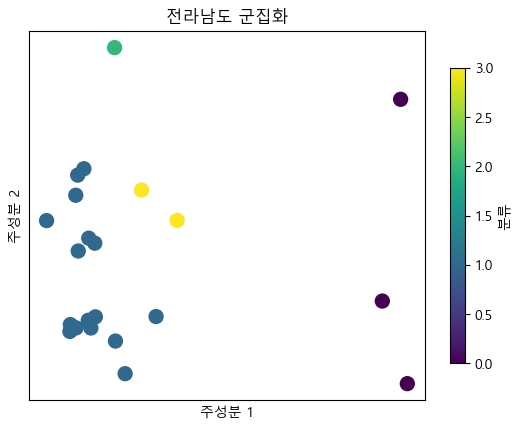

In [316]:
kmeans = KMeans(n_clusters=4,random_state=42)
kmeans.fit(x_pca)

x22=np.arange(len(f_df))
plt.scatter(x_pca[:,0],x_pca[:,1],c=kmeans.labels_,s=100)

plt.xticks([])
plt.xlabel('주성분 1')
plt.ylabel('주성분 2')
plt.yticks([])
plt.colorbar(shrink=0.8,label='분류')

plt.title('전라남도 군집화')
plt.show()

보라색: 순천시, 여수시, 목포시

노란색: 광양시, 무안군

초록색: 담양군

# 시각화

In [317]:
xmin=min(coord_std['경도'])
xmax=max(coord_std['경도'])
ymin=min(coord_std['위도'])
ymax=max(coord_std['위도'])

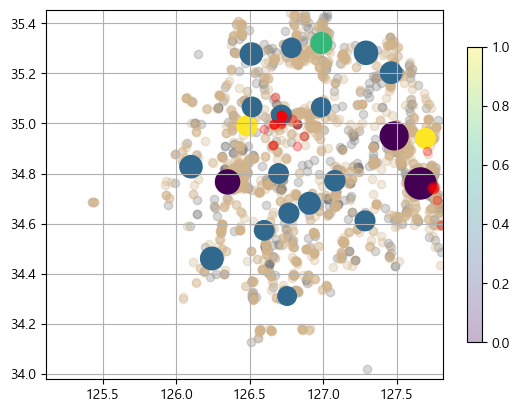

In [341]:
#숙소유형
plt.scatter(x=accomm_df['경도'],y=accomm_df['위도'],alpha=0.3,c='grey')
plt.scatter(x=cafe['경도'],y=cafe['위도'],alpha=0.3,c='tan')

plt.scatter(meal['경도'],meal['위도'],
            c=kmeans.labels_,s=lr_df['최종점수']*100)

plt.scatter(naju['경도'],naju['위도'],alpha=0.3,c='r')
plt.scatter(yeosu['경도'],yeosu['위도'],alpha=0.3,c='r')

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.colorbar(shrink=0.8)

plt.grid()
plt.show()

In [319]:
k_centres=kmeans.cluster_centers_.copy()

# MCLP

관광지            0.957033
음식점개수          0.934554
외지인_평균         0.907142
현지인_평균         0.865225
카페개수           0.839874
현지인_변화량        0.839678

In [320]:
shi=coord_std.groupby('시군구')

min_long=shi['위도'].min()
max_long=shi['위도'].max()
min_lat=shi['경도'].min()
max_lat=shi['경도'].max()

In [321]:
coord_data={'최소위도':min_long, '최대위도':max_long, 
            '최소경도':min_lat, '최대경도': max_lat}

coord_df=pd.DataFrame(coord_data)

In [322]:
coord_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 강진군 to 화순군
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   최소위도    22 non-null     float64
 1   최대위도    22 non-null     float64
 2   최소경도    22 non-null     float64
 3   최대경도    22 non-null     float64
dtypes: float64(4)
memory usage: 880.0+ bytes


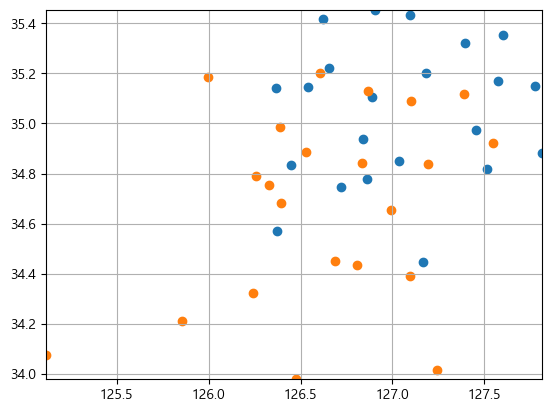

In [323]:
#숙소유형
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.scatter(coord_df['최대경도'],coord_df['최대위도'])
plt.scatter(coord_df['최소경도'],coord_df['최소위도'])

plt.grid()

plt.show()